In [13]:
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import os
import pickle


In [22]:
#Import training data
path = r'C:\Users\attic\HLS_Kelp\imagery\rf_training'
files = os.listdir(path)
training_data = []
#for file in files:
file = r'C:\Users\attic\HLS_Kelp\imagery\rf_training_V2\HLS.L30.T11SKU.2017327T183418.v2.0_kelp_classified.tif'
with rasterio.open(os.path.join(path, file)) as src:
    training_img = src.read()  
file_data = training_img.reshape(training_img.shape[0], -1) 
training_data.append(file_data)

combined_training_data = np.hstack(training_data)

print(combined_training_data.shape)
# plt.figure(figsize=(6, 6))
# plt.imshow(training_img[6,:], cmap='gray')
# plt.show()  
print(combined_training_data[6,0:10])



(7, 13395600)
[3 3 3 3 3 3 3 3 3 3]


In [23]:
X = file_data[0:6,:].T #figured this out by complete chance, organizes it as the transpose. Good to know !!
y = file_data[6,:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [24]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
with open(r'C:\Users\attic\HLS_Kelp\random_forest\rf', 'wb') as f:
    pickle.dump(rf, f)

In [42]:
item = 'HLS.L30.T11SKU.2018362T183359.v2.0'
with rasterio.open(r'C:\Users\attic\HLS_Kelp\imagery\rf_prepped\HLS.L30.T11SKU.2018362T183359.v2.0_rf_ready.tif') as test:
    test_img = test.read()
    transform = test.transform
    crs = test.crs
test_data = test_img.reshape(test_img.shape[0], -1).T
print(test_data.shape)
test_data = test_data[:,0:6]

(13395600, 6)


In [27]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9966839857863776


In [43]:
kelp_pred = rf.predict(test_data)


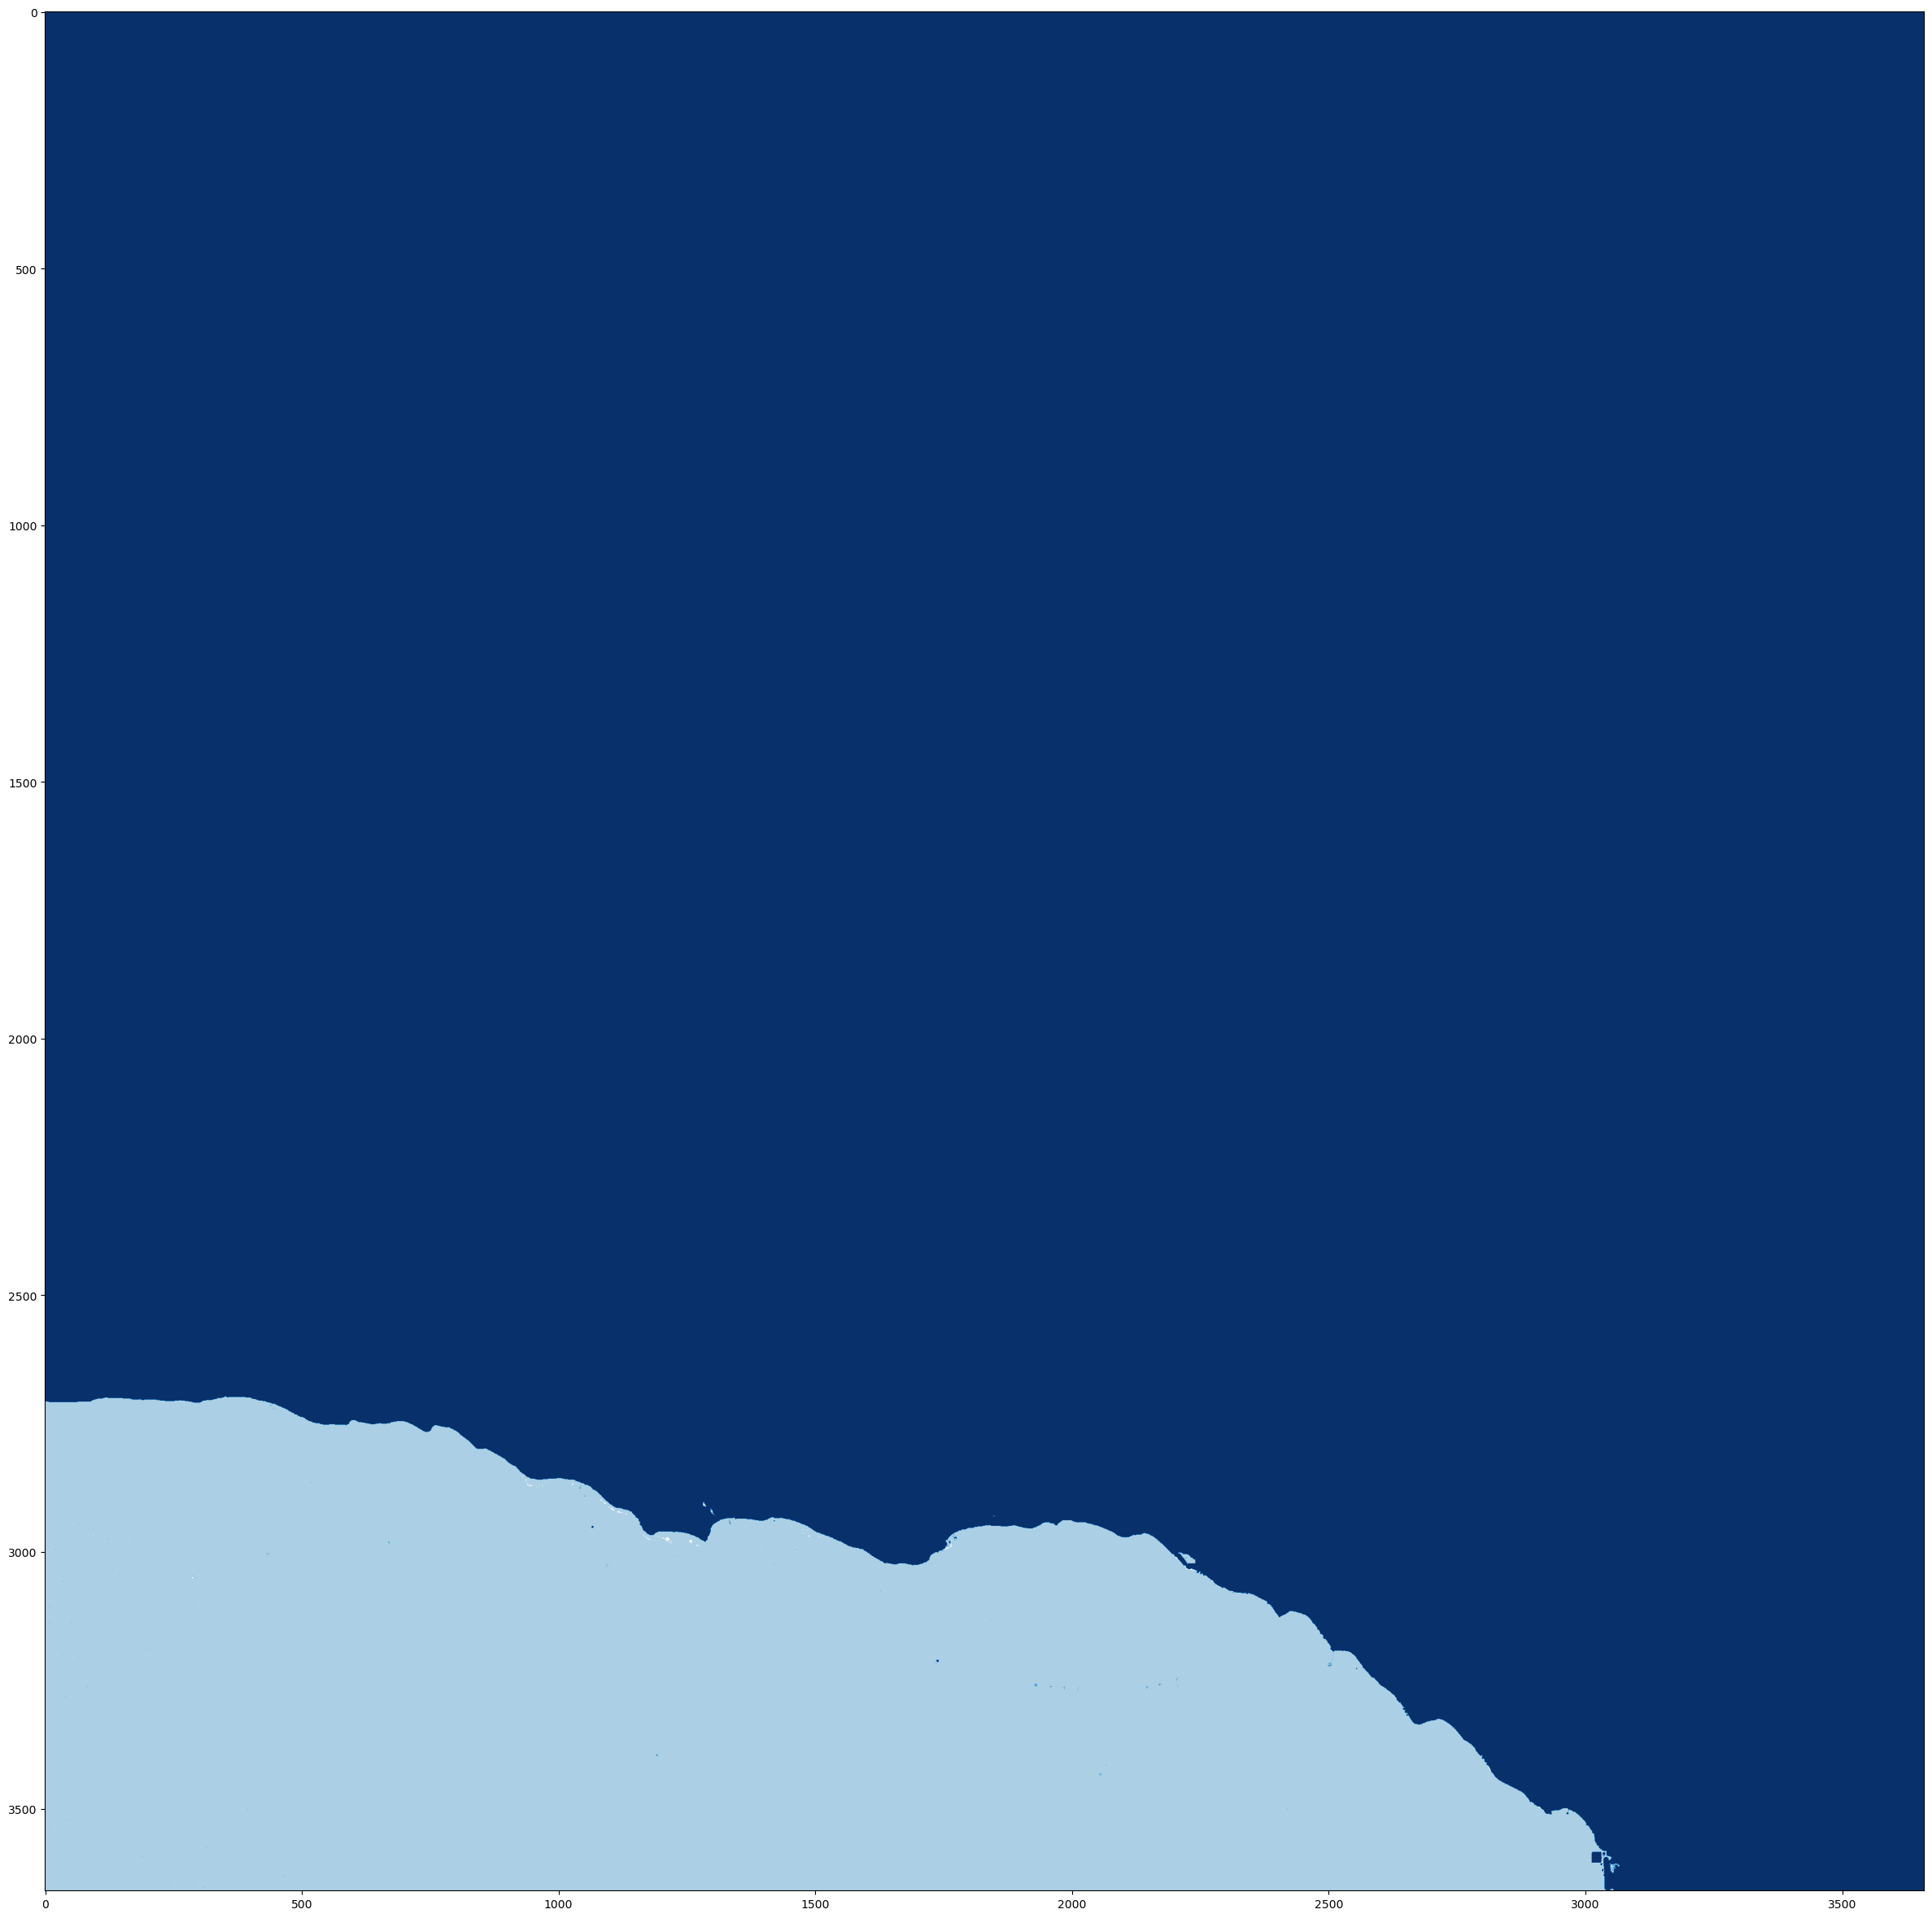

In [44]:
kelp_map = kelp_pred.reshape(3660,3660)

plt.figure(figsize=(30, 30))
plt.imshow(kelp_map, cmap='Blues')

plt.show()  

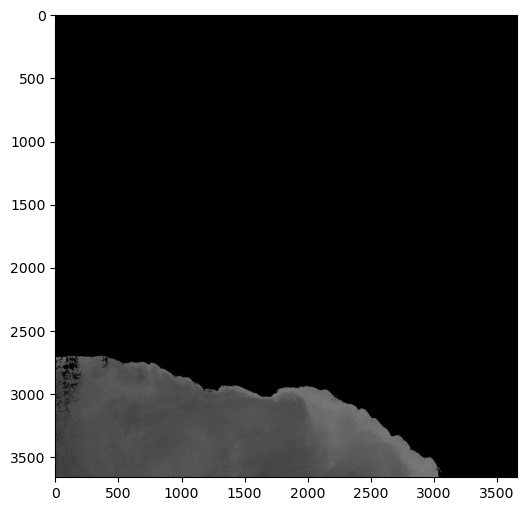

In [41]:

if not os.path.isdir (r'C:\Users\attic\HLS_Kelp\imagery\rf_training_V2'):
    os.mkdir(r'C:\Users\attic\HLS_Kelp\imagery\rf_training_V2')
classification_path = os.path.join(r'C:\Users\attic\HLS_Kelp\imagery\rf_training_V2',f'{item}_kelp_classified.tif')  
height, width = test_img[0].shape
reshaped_normalized_img = test_data.reshape(height, width, 6)
combined_img = np.dstack((reshaped_normalized_img, kelp_map))

plt.figure(figsize=(6, 6))
plt.imshow(combined_img[:,:,1], cmap='gray')
plt.show()  

num_bands = 7
data_type = rasterio.uint8
profile = {
    'driver': 'GTiff',
    'width': width,
    'height': height,
    'count': 7,  # one band
    'dtype': data_type,  # assuming binary mask, adjust dtype if needed
    'crs': crs,
    'transform': transform,
    'nodata': 0  # assuming no data is 0
}
# Write the land mask array to GeoTIFF
with rasterio.open(classification_path, 'w', **profile) as dst:
    for i in range(num_bands):
        dst.write(combined_img[:,:,i].astype(data_type), i + 1)